In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [2]:
!python3 --version

Python 3.10.12


In [3]:
!nvidia-smi

Wed Sep 25 20:52:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   64C    P8              4W /   78W |       7MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Api

In [4]:
import time
import numpy as np
import os
import _pickle as cPickle
import numpy as np
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name as IMAGENET_CLASS_NAMES
import pycuda.autoinit
import pycuda.driver as drv
import numpy
from PIL import Image
import imagehash

from pycuda.compiler import SourceModule

PATH = "../data/cifar-10-batches-py/"
IMAGENET_PATH = "../data/Imagenet/ImageNet32"

In [5]:
def unpickleImages(pairs):
    images = set()
    for elem in pairs:
        images.add(elem[0])
        images.add(elem[1])

    return list(images)

def load_batch(batchFile, path):
    f = open(path+batchFile, 'rb')
    
    dict_ = cPickle.load(f, encoding='latin1')
    images = dict_['data']
    labels = dict_['labels']
    imagearray = np.array(images)   #   (10000, 3072)
    labelarray = np.array(labels)   #   (10000,)
    
    return imagearray, labelarray

def load_classes():
    file = 'batches.meta'
    
    f = open(PATH+file, 'rb')
    dict = cPickle.load(f)
    return dict['label_names']

In [6]:
unpickleImages([(1,2, 0.85),(3,4,0.34)])

[1, 2, 3, 4]

In [7]:
CIFAR_IMAGES, CIFAR_LABELS = load_batch("data_batch_1", PATH)
CIFAR_CLASS_NAMES = load_classes()
CIFAR_IMAGES.shape

(10000, 3072)

In [11]:
#https://stackoverflow.com/questions/78702879/how-to-load-imagenet-from-kaggle
size = 32
batch_size = 10200

transform_train = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101
])

transform_show = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
])

trainset = torchvision.datasets.ImageFolder('./../data/ImageNet/ImageNet32', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

trainset_show = torchvision.datasets.ImageFolder('./../data/ImageNet/ImageNet32', transform=transform_show)
trainloader_show = torch.utils.data.DataLoader(trainset_show, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

print(len(trainset))
print(len(trainloader))

10200
1


In [12]:
def calculate_signature_np(image_file: np.array, hash_size: int) -> np.ndarray:
    pil_image = Image.fromarray(image_file).convert("L").resize(
                        (hash_size+1, hash_size),
                        Image.LANCZOS)
    dhash = imagehash.dhash(pil_image, hash_size)
    signature = dhash.hash.flatten()
    pil_image.close()
    return signature

In [13]:
from typing import List, Dict, Tuple

class cuPerceptual:
    def __init__(self, size, hash_size):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size**2 / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = dict()
        self.hash_size = hash_size
        self.idx = 0

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):  # shingels
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)
    
    def compute_hash(self, images):
        for image in images:
            signature = calculate_signature_np(image.T, self.hash_size)
            self.signatures[self.idx] = np.packbits(signature.astype(np.uint8))
            self.fill_buckets(signature, self.idx)
            self.idx+=1
        return self.signatures

    def compute_candidate(self):
        candidate_pairs = set()
        
        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket) # Why needed ?
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                                tuple([hash_bucket[i],hash_bucket[j]])
                            )
        return candidate_pairs

    def check_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            hd = sum(np.bitwise_xor(
                    np.unpackbits(self.signatures[cpa]), 
                    np.unpackbits(self.signatures[cpb])
            ))
            similarity = (self.hash_size**2 - hd) / self.hash_size**2
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights

In [9]:
torch.set_default_device('cuda:0') 

In [10]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()
model.to('cuda')
print()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
from typing import List, Dict, Tuple

class cuNN:
    def __init__(self, size, hash_size, size_images):
        self.buckets = []
        self.bandsNumber = size
        self.rows = int(hash_size / self.bandsNumber)
        self.hash_buckets_list: List[Dict[int, List[str]]] = [dict() for _ in range(self.bandsNumber)]
        self.signatures = np.zeros([size_images, hash_size//8 ]).astype(np.float32)
        self.hash_size = hash_size
        self.size_ = size_images
        self.idx = 0

        for i in range(size):
            self.buckets.append({})
            
    def fill_buckets(self, signature, idx):
        for i in range(self.bandsNumber):
            signature_band = signature[i*self.rows:(i+1)*self.rows]
            signature_band_bytes = signature_band.tobytes()
            if signature_band_bytes not in self.hash_buckets_list[i]:
                self.hash_buckets_list[i][signature_band_bytes] = list()
            self.hash_buckets_list[i][signature_band_bytes].append(idx)

    def compute_hash(self, imagesF):
        
        tensor_image = torch.FloatTensor(imagesF).to("cuda:0")
        pred = model(tensor_image)
        sigmo = torch.nn.Sigmoid()
        hash_ = sigmo(pred)

        signatures = torch.round(hash_).cpu().detach().numpy().astype(np.int8)

        for signature in signatures:
            self.signatures[self.idx] = np.packbits( signature ).astype(np.float32)
            self.fill_buckets(signature, self.idx)
            self.idx+=1
        return self.signatures
    
    def compute_candidate(self):
        candidate_pairs = set()

        for hash_buckets in self.hash_buckets_list:
            for hash_bucket in hash_buckets.values():
                if len(hash_bucket) > 1:
                    hash_bucket = sorted(hash_bucket)
                    for i in range(len(hash_bucket)):
                        for j in range(i+1, len(hash_bucket)):
                            candidate_pairs.add(
                               tuple([hash_bucket[i], hash_bucket[j]])
                            )
        return candidate_pairs
    
    def check_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size - hd) / self.hash_size
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

    def recheck_candidate(self, candidate_pairs, threshold=0.9):
        near_duplicates = list()
        for cpa, cpb,_ in candidate_pairs:
            item_cpa = np.array(self.signatures[cpa]).astype(np.uint8)
            item_cpb = np.array(self.signatures[cpb]).astype(np.uint8)
            hd = sum(np.bitwise_xor(
                    np.unpackbits(item_cpa), 
                    np.unpackbits(item_cpb)
            ))
            similarity = (self.hash_size - hd) / self.hash_size
            if similarity > threshold:
                near_duplicates.append((cpa, cpb, similarity))
                
        # Sort near-duplicates by descending similarity and return
        near_duplicates.sort(key=lambda x:x[2], reverse=True)
        return near_duplicates

In [130]:
batch = next(iter(trainloader))
batch_show = next(iter(trainloader_show))

IMAGENET_IMAGES, IMAGENET_LABELS = batch
IMAGENET_IMAGES_SHOW, _ = batch_show
print(IMAGENET_IMAGES.shape)
print(IMAGENET_LABELS.shape)


#IMG = CIFAR_IMAGES[0:10000].reshape(10000,3,32,32)
#LABELS = CIFAR_LABELS
#print(IMG.shape)

IMG = IMAGENET_IMAGES
LABELS = IMAGENET_LABELS
print(IMG.shape)

torch.Size([10200, 3, 32, 32])
torch.Size([10200])
torch.Size([10200, 3, 32, 32])


In [38]:
#nnLSH = cuNN(8, 64, IMG, len(IMG))
nnLSH = cuNN(25, 1000, len(trainset))
for IMG, LABELS in trainloader:
    signatures = nnLSH.compute_hash(IMG)
    print(signatures.shape)
pairs = nnLSH.compute_candidate()
print(len(pairs))
duplicates = nnLSH.check_candidate(pairs, 0.95)
print(len(duplicates))

image = IMG.detach().cpu().numpy()
image = image.astype(np.uint8)

perceptualLSH = cuPerceptual(8, 8)
perceptualLSH.compute_hash(image)
duplicates2 = perceptualLSH.recheck_candidate(duplicates,0.9)
print(len(duplicates2))


(10200, 125)
418811
188
41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

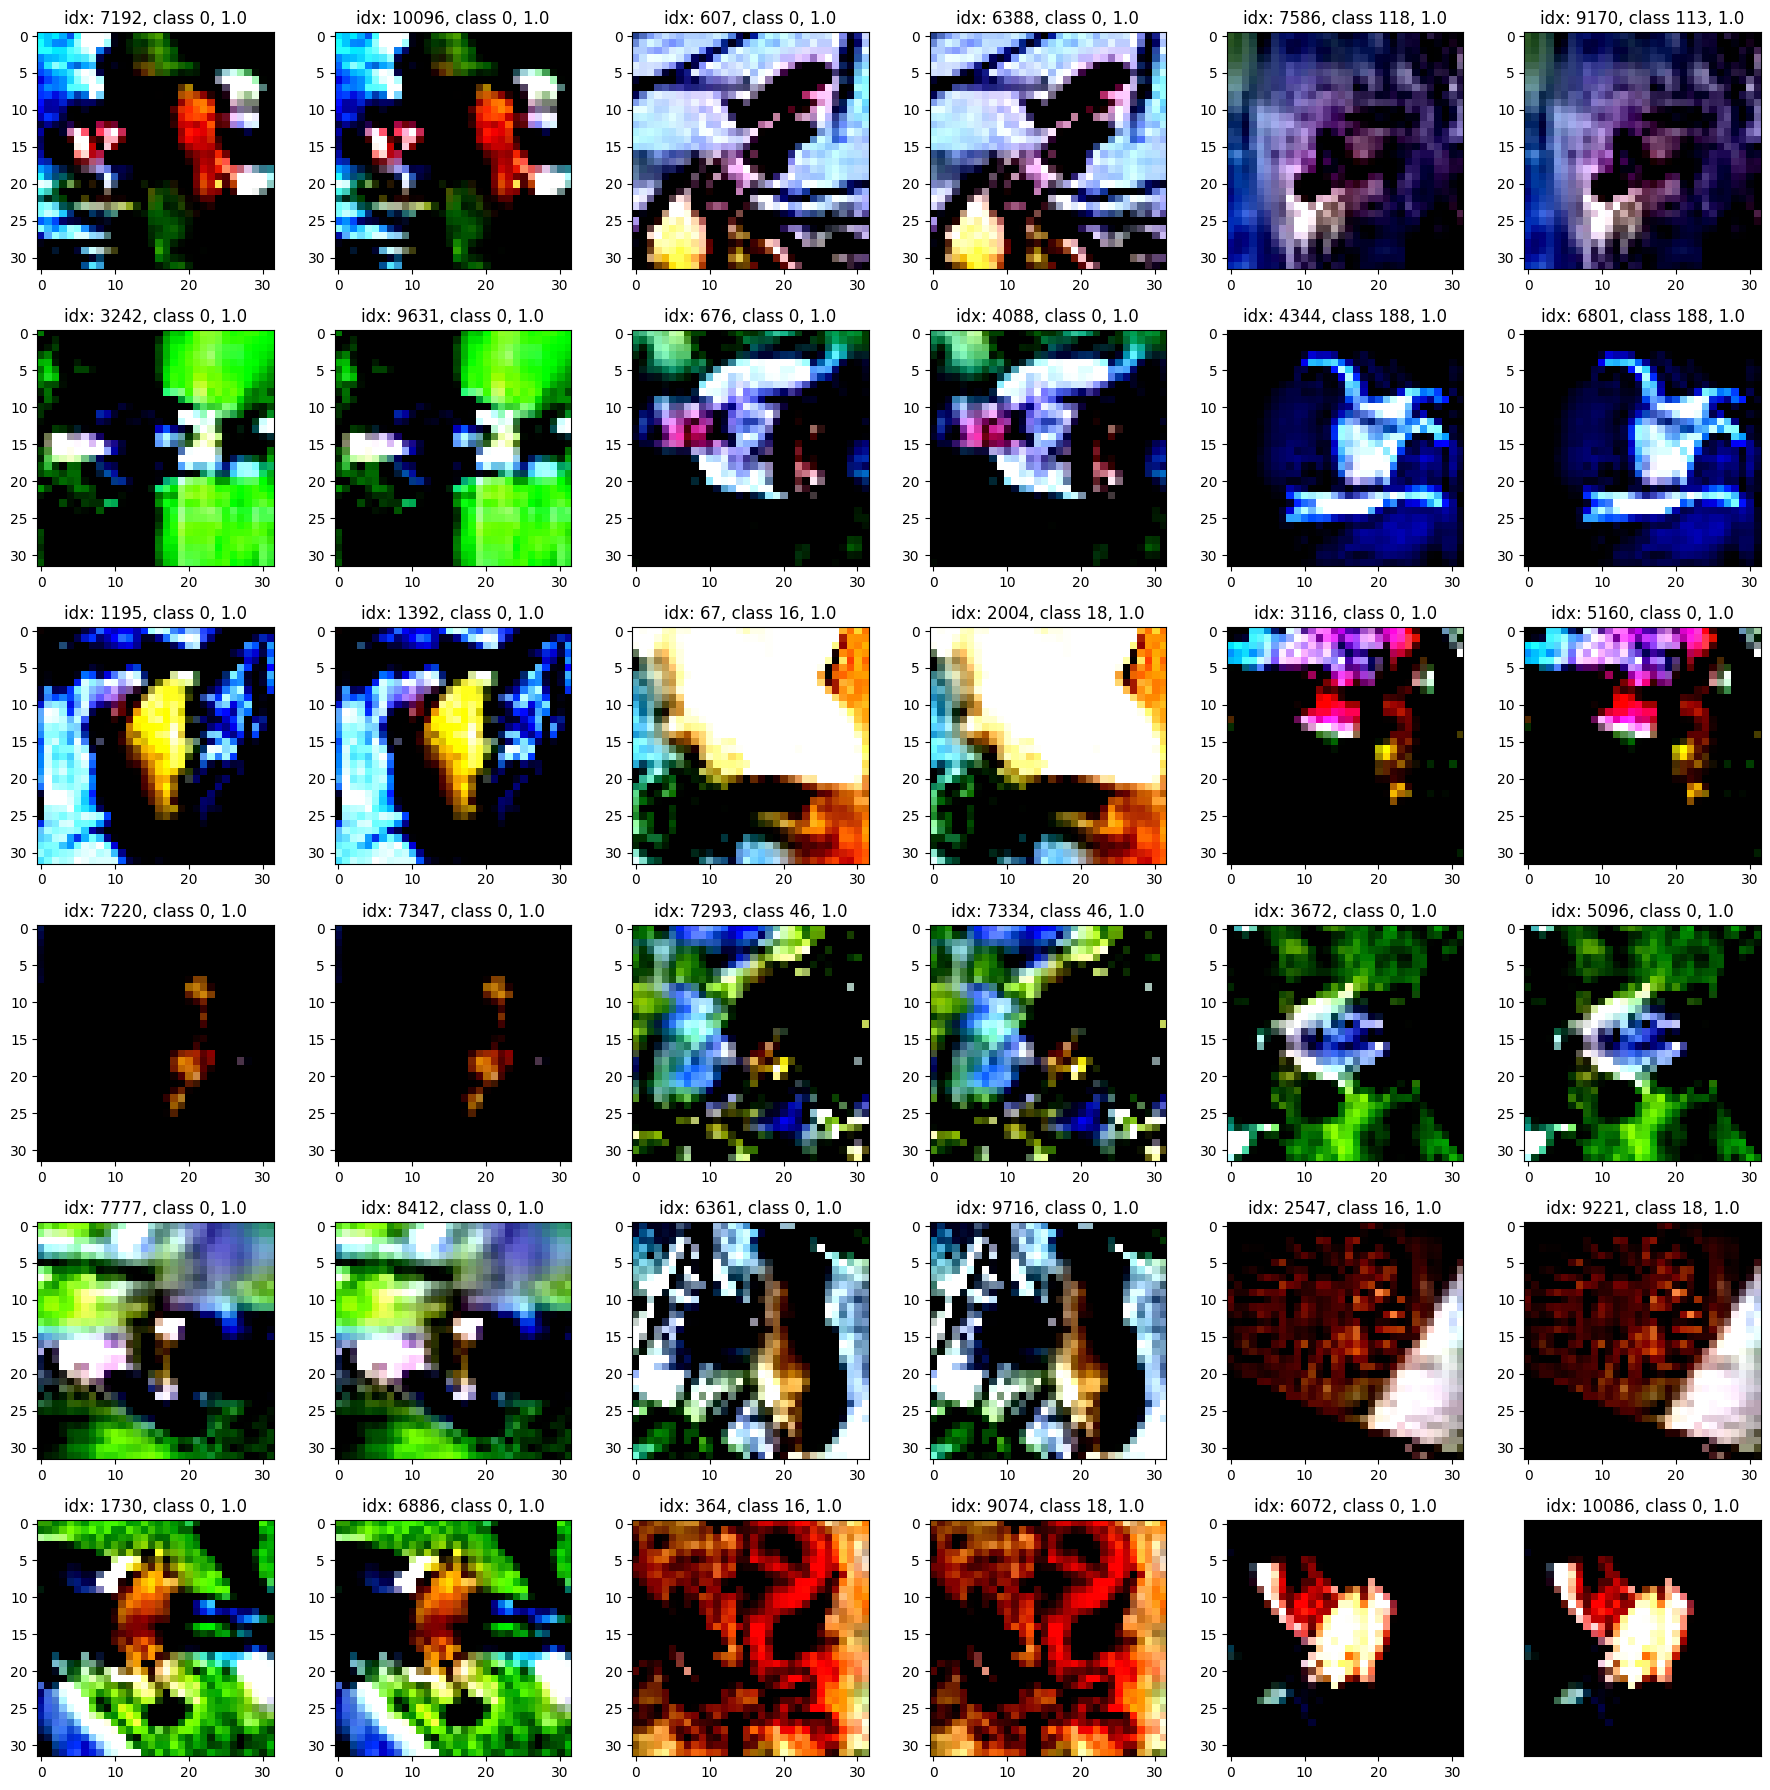

In [39]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""idx: {duplicates[i + idx_start ][0]}, class {LABELS[duplicates[i + idx_start ][0]]}, {duplicates[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""idx: {duplicates[i + idx_start][1]}, class {LABELS[duplicates[i + idx_start][1]]}, {duplicates[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [40]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates) - withoutLastElements ):
    if LABELS[duplicates[i][0]] == LABELS[duplicates[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates) - withoutLastElements )
print(acc)

True duplicates:  45
All duplicates:  188
0.2393617021276596


In [41]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates2) - withoutLastElements ):
    if LABELS[duplicates2[i][0]] == LABELS[duplicates2[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates2) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates2) - withoutLastElements )
print(acc)

True duplicates:  32
All duplicates:  41
0.7804878048780488


# Second 

In [42]:
perceptualLSH = cuPerceptual(8, 8)
perceptualLSH.compute_hash(IMG.detach().cpu().numpy().astype(np.uint8))
pairs3 = perceptualLSH.compute_candidate()
duplicates3 = perceptualLSH.check_candidate(pairs3,0.95)
print(len(duplicates3))

nnLSH = cuNN(40, 1000, len(IMG))
signatures4 = nnLSH.compute_hash(IMG)
duplicates4 = nnLSH.recheck_candidate(duplicates3, 0.9)
print(len(duplicates4))


2900
40


In [43]:
# Treshold wwazny zeby odfiltrowac nie duplikaty
# Porownywanie duplikatow zdjec - przy podwojnym filtrowaniu ???
# 6 milionow par potencjalych przy sieci neuronowej
# Pierw musi chodzic PyCUDA poniej doperio cos PyTorch, zeby nie bylo przeklama w dostepie do cuda

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

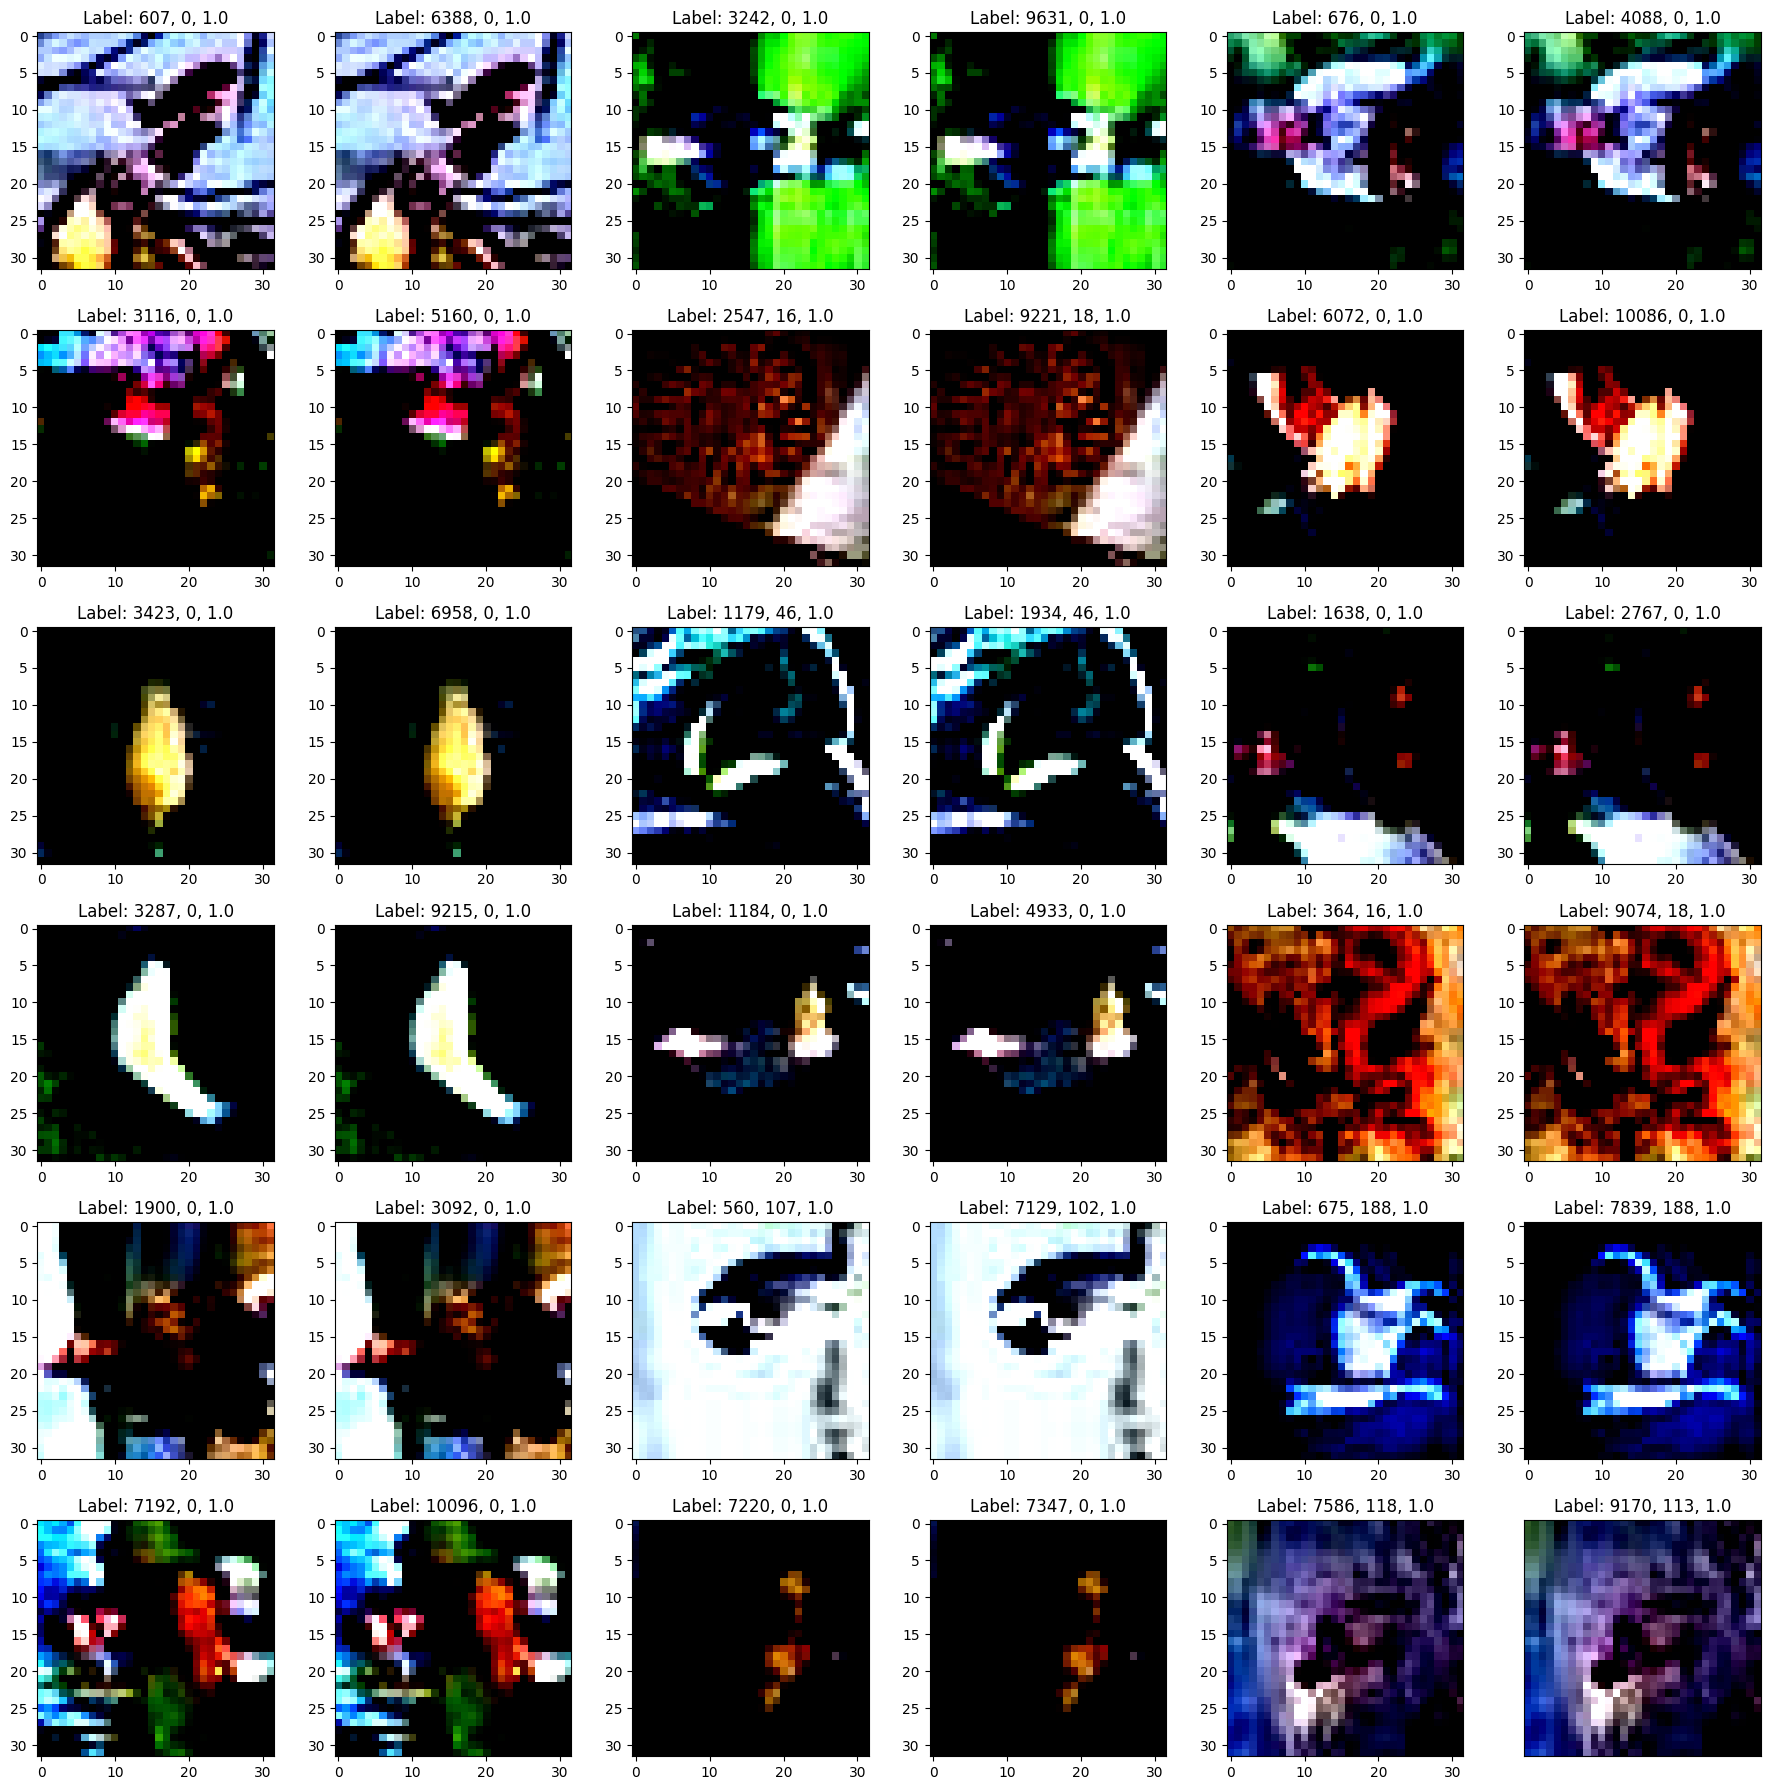

In [44]:
from matplotlib import pyplot as plt

num_row = 6
num_col = 6
col_idx = 0
row_idx = 0

idx_start = 0;

fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(0, num_row*num_col//2, 1):
    if col_idx >= num_col -1:
        col_idx = 0
        row_idx += 1
    
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates4[i + idx_start ][0]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start ][0]}, {LABELS[duplicates4[i + idx_start ][0]]}, {duplicates4[i + idx_start][2]}""")

    col_idx += 1
    ax = axes[row_idx, col_idx]
    ax.imshow(IMG[duplicates4[i + idx_start][1]].reshape(3,32,32).T)
    ax.set_title(f"""Label: {duplicates4[i + idx_start][1]}, {LABELS[duplicates4[i + idx_start][1]]}, {duplicates4[i + idx_start][2]}""")
    col_idx += 1

plt.tight_layout()
plt.xticks([])
plt.yticks([])

plt.show()

In [45]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates3) - withoutLastElements ):
    if LABELS[duplicates3[i][0]] == LABELS[duplicates3[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates3) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates3) - withoutLastElements )
print(acc)

True duplicates:  78
All duplicates:  2900
0.02689655172413793


In [46]:
withoutLastElements = 0#577600
sumTrueDuplicates = 0
for i in range( len(duplicates4) - withoutLastElements ):
    if LABELS[duplicates4[i][0]] == LABELS[duplicates4[i][1]]:
        sumTrueDuplicates += 1
        

print("True duplicates: ", sumTrueDuplicates)
print("All duplicates: ", len(duplicates4) - withoutLastElements )
acc = sumTrueDuplicates / ( len(duplicates4) - withoutLastElements )
print(acc)

True duplicates:  29
All duplicates:  40
0.725


In [68]:
wejscie = IMAGENET_IMAGES[8561].reshape(1,3,32,32)
wejscieTensor = torch.FloatTensor(wejscie).to("cuda:0")
pred = model( wejscieTensor )
print(IMAGENET_LABELS[8561])
print(torch.max(pred,1)[1])

859
tensor([470], device='cuda:0')
